### Add libraries

In [156]:
#libraries
import numpy as np
import matplotlib as plt
import plotly.graph_objects as go
import math

In [157]:
# tef,dtt,a: array [0..1501] of longint# 
# tav,ms,Ω,djs,djs1,μ,φ,Rsat,Xsp,Xsp1,PerSat,dφs,t2,t1,Jsc,Jr1,Jr2,j12,tpl1,tpl2:array [0..1500] of real# 
# t1s,t2s,te1s,te2s,Jadd1,Jadd2,k: array [1..10,0..1501] of real#
# Pp,Ps,Rp,Ap,m,Mp,φp,dφp,dt1:longint# 
# dt,n,ts,s,t:longint# 
# Rs,xp,xp1,Xplo,Xpl,Xpln,Xpln1,Xpl1o,G,Mstar,Mplanet,Ωp,F,f1,Alb:real# 
# delt,tint,i:integer# 
# delj,dttav,jav,sigmajdtt,sigmaj,sigmadtt,Jres,Jcut,Jcuto:real#
# PpObs,t0,Korr,TTVmax,TTVmin:real# 
# PerP:real#

# Jo:array [0..1500,-70000..70000] of real#
# V1,V2,V3,V4,V5,L,S3,djp1,djp,djp0:real#
# Rz,Aps,Ass:longint# 

# xs,xs1,dJ:real# 

# te1,te2:integer# 

# nn,sumn,ntav,sumtav,Delta,DeltaPp,Deltat0:real# 

### Define all the constants i.e. star/planet/moons/noise

In [455]:
m=2;
step=8
ms=[None]*3
a=[None]*3
Rsat=[None]*3

G=6.67*10**(-11)#
Mstar=1.99*10**30#
Mplanet=5.99*10**24#

Mp=1#{Масса планеты в относительных единицах}
ms[0]=1/81.3#{Масса спутника-1 в массах планеты}
ms[1]=1/95#{Масса спутника-2 в массах планеты}
ms[2]=1/98#
Ap=149598000# {Большая полуось орбиты планеты в км} 
Pp=31556952# {Период обращения планеты вокруг звезды в сек}
Ps=245000# {Период обращения спутника вокруг планеты в сек} 
Rp=6400# {Радиус планеты в км} 
Rs=695000# {Радиус звезды в км} 

a[0]=384000#{Радиус орбиты спутника-1 в км}
a[1]=609562#{Радиус орбиты спутника-2 в км}
a[2]=699000#

Rsat[0]=1738# {Радиус спутника-1 в км} 
Rsat[1]=1450# {Радиус спутника-2 в км} 
Rsat[2]=1950#
Alb=0.3#
s=500# {Число транзитов системы спутники-планета}  
tint=6500# {Время усреднения яркости до/после затмения в сек} 
delJ=0.000007#{Погрешность измения яркости, случайная добавка принимает значения от delJ до +delJ, всегда равна нулю при delt=0} 
delt=6# {Погрешность изменения времени транзита, принимает значения от -delt до +delt, в сек} 
φp=0# what is it?
Ωp=np.sqrt(G*Mstar/1000000000/Ap/Ap/Ap)#
Vp=np.sqrt(G*Mstar/1000000000/Ap)
djp=(Rp/Rs)**2#
djp0=Rp/Rs#
PerP=2*np.pi/Ωp#
Ω=[None]*m
djs=[None]*m
μ=[None]*m
dφs=[None]*m
PerSat=[None]*m
φ=[None]*m
dφs=[None]*m
t1=[None]*s   
t2=[None]*s
Xsp=[0]*m
Xspprev=[0]*m
djs1=[0]*m
tpl1=[None]*s
tpl2=[None]*s
Ω=[None]*m
w1 = s
T=70000
t1s = [[0 for x in range(m)] for y in range(w1)] 
t2s = [[0 for x in range(m)] for y in range(w1)] 
te1s = [[0 for x in range(int(-T/step),int(T/step))] for y in range(w1)] 
te2s= [[0 for x in range(int(-T/step),int(T/step))] for y in range(w1)] 
Jo= [[0 for x in range(int(-T/step),int(T/step))] for y in range(w1)] 
Xpprev=0
Xplnprev=0
dur=2*Rs/Vp    #transit duration

### Parameters of the moons

In [456]:
for i in range(m):
    Ω[i]=np.sqrt(G*Mplanet/1000000000/a[i]/a[i]/a[i])# {Доп. коэфф. необходим при переводе из км в метры}
    djs[i]=(Rsat[i]**2)/(Rs**2)# {Изменение яркости звезды во время транзита i-го спутника}
    μ[i]=(Mp/ms[i])# {Отношение масс i-го спутника к массе планеты.}
    print(Ω[i])
    print('djs= ', djs[i])#
    print('μ=', μ[i])#
#     PerSat[i]=2*np.pi/Ω[i]#
    dφs[i]=(Ω[i]*(PerP-dur)/2/np.pi-int(Ω[i]*(PerP-dur)/2/np.pi))# Phase shift?+np.pi/2
    print('Ps-',i,'=',PerSat[i])#
    print('dφs-',i,'=',dφs[i])#
    
print('Pp=',PerP)#

2.6563144917024576e-06
djs=  6.253597639873713e-06
μ= 81.3
Ps- 0 = None
dφs- 0 = 0.32097483860699505
1.3281572587799613e-06
djs=  4.352776771388645e-06
μ= 95.0
Ps- 1 = None
dφs- 1 = 0.6604874841389377
Pp= 31555792.695338428


### Loop over s transits

In [457]:
#we have to understand this loop
tpl1=[-23540]*s
tpl2=[23550]*s
# print(len(Jo))

for n in range(s):
    if n %10==0:
        print(n)
        
    #{n-transit's number}
    for i in range(m):
        φ[i]=2*np.pi*(n*dφs[i]-int(n*dφs[i]))# current phase of each satellite?
#         print(φ[i],'i=',i)
    
    t=-T#  
    while t<T: #by 10 second iteration
        t=t+step#
        
        Jo[n][int(t/step)]=1
#         dt=dt+5
        Xplo=0#
        for i in range(m):#Contribution of every satellite to planet's position
            Xplo=Xplo-(a[i]/(μ[i]+1)*np.sin(Ω[i]*t+φ[i]))
        Xp=0#
        Xp=Xplo+Ap*np.sin(Ωp*t+φp)#{координата центра планеты в момент t}
#         Xp1=0#
#         Xp1=Xplo+Ap*np.sin(Ωp*(t+5)+φp)#{координата центра планеты в момент t+1}
#         print('Xp=',Xp)
#         print('Xp=',Xp)
        
        
        #every time check the condition:
        
        if (-Xpprev>Rs+Rp) and (-Xp<Rs+Rp):
            t1[n]=t# {Условие вступления центра планеты на диск звезды, t1[n]-время начала n-го транзита в сек}
        if (Xpprev<Rs+Rp) and (Xp>Rs+Rp):
            t2[n]=t# {Условие схода центра планеты с диска звезды, t2[n]-время окончания n-го транзита в сек}
        Xpprev=Xp
        
#{Транзиты планеты без участия спутников}
#         Xpln=Ap*np.sin(Ωp*t+φp)
#         Xpln1=Ap*np.sin(Ωp*(t+1)+φp)#
        
#         if (-Xplnprev>Rs+Rp) and (-Xpln<Rs+Rp):
#             tpl1[n]=t# {Условие вступления центра планеты на диск звезды, tpl1[n]-время начала n-го транзита в сек}
#         if (Xplnprev<Rs+Rp) and (Xpln>Rs+Rp):
#             tpl2[n]=t# {Условие схода центра планеты с диска звезды, tpl2[n]-время окончания n-го транзита в сек} 
#         Xplnprev=Xpln  
#         print('Xpl',Xp, 't=',t)

        
    
        for i in range(m):
            Xspprev[i]=Xsp[i]
            Xsp[i]=Xp+a[i]*(μ[i]/(μ[i]+1))*np.sin(Ω[i]*t+φ[i])# {координата центра спутника в момент t}
#             print('Xspprev=',Xspprev[i],'t=',t)
#             Xsp1[i]=Xp1+a[i]*(μ[i]/(μ[i]+1))*np.sin(Ω[i]*(t+1)+φ[i])# {координата центра спутника в момент t+1}
            if (-Xspprev[i]>Rs) and (-Xsp[i]<Rs):
                t1s[n][i]=t # {Условие вступления центра спутника на диск звезды, t1s[n]-время начала n-го транзита в сек} 
#                 print('t=',t)
            if (Xspprev[i]<Rs) and (Xsp[i]>Rs):
                t2s[n][i]=t# {Условие схода центра спутника с диска звезды, t2[n]-время окончания n-го транзита в сек}
#                 print('t=',t)
#             print('Xsp=',Xsp)
            
        for i in range(m):
            l=0
            S3=0
            v3=0 # what is it?
            v1=0
            v2=0
            if (abs(Xsp[i])<(Rs+Rsat[i])) and (abs(Xsp[i])>Rs):
                v1=1
            else:
                v1=0
                
            if  (abs(Xsp[i])>(Rs-Rsat[i])) and (abs(Xsp[i])<Rs):
                v2=1 
            else:
                v2=0
            if abs(Xsp[i])<(Rs-Rsat[i]):
                v3=1
            else:
                v3=0
            djs1[i]=0 
            if v1>0 or v2>0:
#                 Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs[i]*0.5
#             if v3>0:
#                 Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs[i]
# #                 print('Xsp[i]=', Xsp[i])
                l=np.sqrt(Rsat[i]**2-(abs(Xsp[i])-Rs)**2)
                S3=np.arccos(abs(-Rs+abs(Xsp[i]))/Rsat[i])*Rsat[i]**2-l*abs(-Rs+abs(Xsp[i]))
                djs1[i]=S3/(np.pi*Rs*Rs)
#             Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs1[i]*v1-(djs[i]-djs1[i])*v2-djs[i]*v3#

            Jo[n][int(t/step)]=Jo[n][int(t/step)]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xsp[i]))*(abs(Xsp[i]))/Rs/Rs)))*(djs1[i]*v1+(djs[i]-djs1[i])*v2+djs[i]*v3)   
#             print(Jo[n][int(t/10)])
#             print('v3=',v3)
#             print('Jo1=',Jo[n][int(t/10)])
        v3=0 # what is it?
        v1=0
        v2=0
        if (abs(Xp)<(Rs+Rp)) and (abs(Xp)>Rs):
            v1=1
        else:
            v1=0 
        if  (abs(Xp)>(Rs-Rp)) and (abs(Xp)<Rs):
            v2=1 
        else:
            v2=0
        if abs(Xp)<(Rs-Rp):
            v3=1
        else:
            v3=0
        l=0
        S3=0
        djp1=0
        if v1>0 or v2>0:
#             print('t=',t)
#             print('Xp=', Xp)
#             l=abs(abs(Xp)-Rs)
#             print('l=',l)
#             S3=1/2*(Rp**2)*np.arcsin(2*l*np.sqrt(Rp**2-l**2)/Rp**2)-l*np.sqrt(Rp**2-l**2)
            l=np.sqrt(Rp**2-(abs(Xp)-Rs)**2)
            S3=np.arccos(abs(-Rs+abs(Xp))/Rp)*Rp*Rp-l*abs(-Rs+abs(Xp))#
            djp1=S3/(np.pi*Rs*Rs)
#             Jo[n][int(t/10)]=1-djp1*v1-(djp-djp1)*v2#
#         if v3>0:
#             Jo[n][int(t/10)]=1-djp*v3
            
#         v3=1
        Jo[n][int(t/step)]=Jo[n][int(t/step)]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xp))*(abs(Xp))/Rs/Rs)))*(djp1*v1+(djp-djp1)*v2+djp*v3)
#         print('Jo2=',Jo[n][int(t/10)],'t=',t) 
# print('J=',Jo[n][int(t/10)])

#             djp1=(S3/(np.pi*Rs*Rs))#
            
#         Jo[n][t]=Jo[n][t]-(djp1*(V1+V5)+(djp-djp1)*(V2+V4)+djp*V3)#
#          {Jo[n,t]=Jo[n,t]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xp))*(abs(Xp))/Rs/Rs)))*(djp1*(V1)+(djp-djp1)*(V2)+djp*V3)#}

#     print(t1[n])
#     print(t2[n])
# print(t1s)
# print(t2s)
print('tpl1=',tpl1)
print('tpl2=',tpl2)
#     for i in range(m):
#         te1s[n][i]=t1[n]-t1s[n][i]#{Продолж. нахождения спутников на диске звезды до и после транзита планеты}
#         te2s[n][i]=t2s[n][i]-t2[n]#

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
tpl1= [-23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -23540, -235

In [459]:
from scipy.stats import spearmanr 
Jr1=[0]*s
Jr2=[0]*s
J12=[0]*s
tav=[0]*s
nn=0
sumn=0
ntav=0
sumtav=0

for n in range(s):
    for t in range(np.round(t1[n]-tint),np.round(t1[n])):
                   Jr1[n]=Jr1[n]+Jo[n][int(t/step)]
              
    for t in range(np.round(t2[n]),np.round(t2[n]+tint)):
                   Jr2[n]=Jr2[n]+Jo[n][int(t/step)]#

                   
for n in range(s):
#     print(n,'Jr1= ',Jr1[n])#
#     print(n,'Jr2= ',Jr2[n])# 
    Jr1[n]=Jr1[n]/tint#
    Jr2[n]=Jr2[n]/tint#
    J12[n]=Jr2[n]/Jr1[n]# {отношение j2[n] и j1[n]}
#     {j12[n]=j12[n]+2*delj*(np.random(delt+1)-(delt+1)/2)/(delt+1)#}
#     print('J12[',n,']=',J12[n],'#')#


# for n in range(s):
#     t1[n]=t1[n]+2*Random(delt+1)-(delt+1)#{Эта строчка и две следующие - случайные погрешности
#     t2[n]=t2[n]+2*Random(delt+1)-(delt+1)# }


for n in range(s):
    tav[n]=np.round((t1[n]+t2[n])/2)# {tav[n]-время середины n-того
    nn=nn+n*n# {отсюда и до конца абзаца составление эфемериды планеты методом наименьших квадратов
    sumn=sumn+n# 
    ntav=ntav+n*tav[n]# 
    sumtav=sumtav+tav[n]# 


Delta=nn*(s+1)-sumn*sumn# 
DeltaPp=ntav*(s+1)-sumtav*sumn# 
Deltat0=nn*sumtav-sumn*ntav# 
PpObs=DeltaPp/Delta# 
t0=Deltat0/Delta

                   
             
print('Pp=', PpObs,' t0=',t0)# {ppObs-наблюдаемый период обращения планеты вокруг звезды, на основе известных времен транзитов в сек} 
# {t0- постоянная, входящая в эферемениду, измеряется в сек} 



tef=[0]*s
dtt=[0]*s
x=[]
y=[]
for n in range(s):

    tpl1[n]=PpObs*(n-np.arcsin(Rs/Ap)/2/np.pi)#
    tpl2[n]=PpObs*(n+np.arcsin(Rs/Ap)/2/np.pi)#}
    dtt[n]=np.round(tav[n])-tef[n]# {dtt[n] - вариация времени середины n-того транзита планеты в сек
    tef[n]=np.round(n*PpObs+t0)# tef[n] - время середины n-того транзита планеты согласно эфемериде в сек} 
    dtt[n]=np.round((t1[n]-tpl1[n]+t2[n]-tpl2[n])/2)# {dtt[n] - вариация времени середины n-того транзита планеты в сек} 
    
    x.append(dtt[n])
    y.append(-(1-1/J12[n])*1000000)  
    
    r,p=spearmanr(x,y)
#     print(r)
#     print(p)
    
#     print('dtt[n]=','  ',dtt[n])#
#     print('TDV[',n,']=',-(tpl2[n]-tpl1[n])+(t2[n]-t1[n]),'#')#}
#     print('[',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,',',(1-1/J12[n])*1000000,']',',')# 
    
#     print('[',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,',', -(tpl2[n]-tpl1[n])+(t2[n]-t1[n]),']',',')#}
#     print('TTV[',n,']=',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,'#')
    
 



# dttav=0
# Sigmaj=0
# Sigmadtt=0
# Sigmajdtt=0    
    
    
# For n in range(s):
#     jav=jav+j12[n]/(s+1)# print('jav=',jav:8:8)#    
#     dttav=dttav+dtt[n]/(s+1)# print('dttav=',dttav:8:4)#    
#     Sigmaj=Sigmaj+j12[n]*j12[n]-jav*jav# Sigmaj=np.sqrt(Sigmaj)#    
#     Sigmadtt=Sigmadtt+dtt[n]*dtt[n]-dttav*dttav# Sigmadtt=np.sqrt(Sigmadtt)#    
#     Sigmajdtt=Sigmajdtt+(j12[n]-jav)*(dtt[n]-dttav)#     
    



# print(Sigmaj,' ',Sigmadtt,' ',Sigmajdtt)# 
# Korr=Sigmajdtt/Sigmaj/Sigmadtt# 
# print('Коэффициент корреляции, Korr=', Korr:4:3)# 


Pp= -0.0012646385373460607  t0= 4.147232849369104


In [360]:
x1=[]
y1=[]
for i in range(len(x)):
    if x[i]>0 and y[i]<0:
        x1.append(x[i])
        y1.append(y[i])

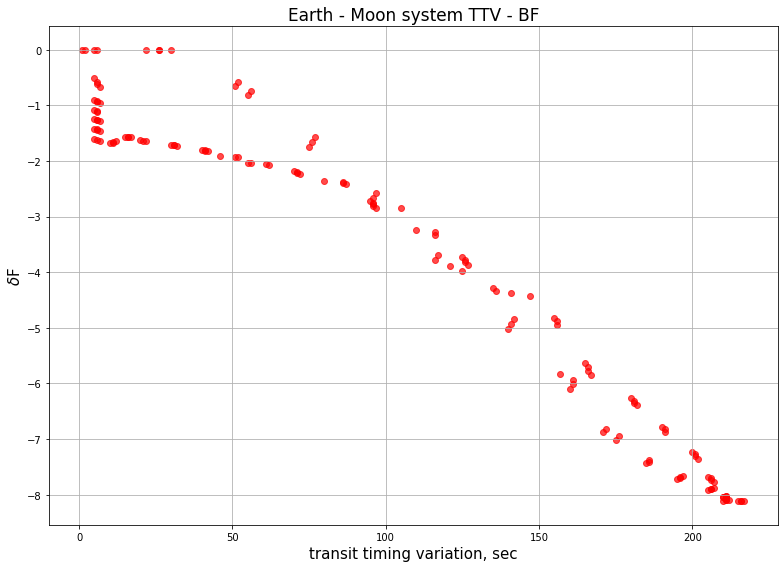

In [361]:
fig, ax = plt.subplots()
ax.scatter(x1, y1, alpha=0.7,c='r')

ax.set_xlabel(r'transit timing variation, sec', fontsize=15)
ax.set_ylabel(r'$\delta$F', fontsize=15)
ax.set_title('Earth - Moon system TTV - BF',fontsize=17)
fig.set_size_inches(11,8)
ax.grid(True)
fig.tight_layout(h_pad=5,w_pad=10)

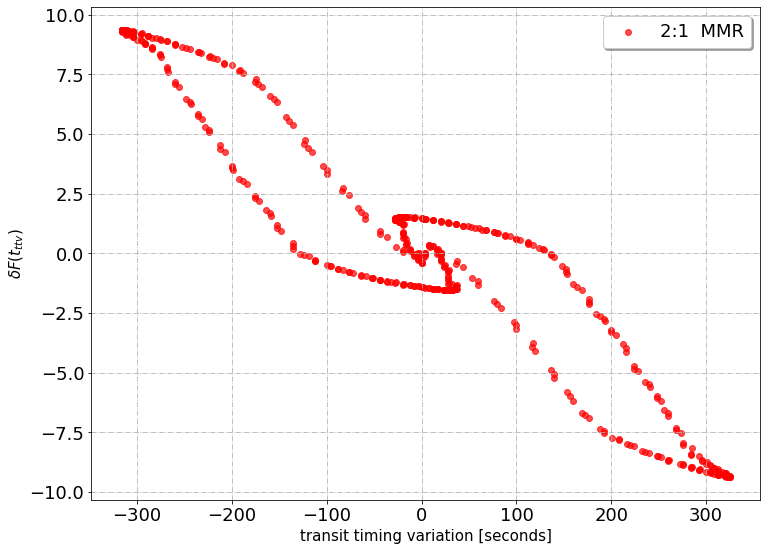

In [476]:
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.7,c='r',label='2:1  MMR')

ax.set_xlabel(r'transit timing variation [seconds]', fontsize=15)
ax.set_ylabel(r'$\delta F(t_{ttv})$', fontsize=15)
# ax.set_title('Earth - Moon system TTV - BF',fontsize=17)
fig.set_size_inches(11,8)
# ax.tick_params(axis='x', labelsize=18)
matplotlib.rc('font', size=18)
ax.legend(shadow=True)
ax.grid(True,ls='-.')
fig.tight_layout(h_pad=5,w_pad=10)

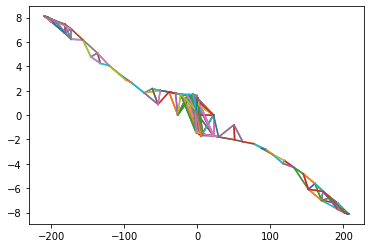

In [410]:
x1=[0]*2
y1=[0]*2
for i in range(len(x)):
    for j in range(len(x)):
        l=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
        if l<=23:
            x1[0]=x[i]
            x1[1]=x[j]
            y1[0]=y[i]
            y1[1]=y[j]
            
#             x1.append(x[i])
#             y1.append(y[i])
#             x1.append(x[j])
#             y1.append(y[j]           
            plt.plot(x1, y1)
plt.show()    

In [132]:
t = np.linspace(0, 10, 100)
# pio.templates.default = "simple_white"
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    name='TTV-BF', mode='lines',
    marker_color='rgba(255, 182, 193, .9)'
))
fig.update_layout(
    xaxis_title="TTV, sec",
    yaxis_title="BF, nomalized units")
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='TTV-BF for Earth-Moon with initial orbital speed',
                  yaxis_zeroline=True, xaxis_zeroline=False,plot_bgcolor= "rgb(255, 255, 255)")
# hovermode='closest'
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgb(0, 255, 255)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgb(0, 255, 255)')
fig.show()

In [357]:
x

[5.0,
 80.0,
 -35.0,
 -70.0,
 125.0,
 -10.0,
 -135.0,
 165.0,
 5.0,
 -175.0,
 200.0,
 5.0,
 -200.0,
 215.0,
 5.0,
 -200.0,
 205.0,
 5.0,
 -180.0,
 175.0,
 10.0,
 -140.0,
 125.0,
 30.0,
 -95.0,
 55.0,
 55.0,
 -55.0,
 -20.0,
 95.0,
 -20.0,
 -95.0,
 135.0,
 -5.0,
 -150.0,
 180.0,
 5.0,
 -185.0,
 205.0,
 5.0,
 -205.0,
 210.0,
 5.0,
 -195.0,
 195.0,
 5.0,
 -165.0,
 160.0,
 15.0,
 -125.0,
 105.0,
 40.0,
 -85.0,
 30.0,
 70.0,
 -45.0,
 -45.0,
 110.0,
 -15.0,
 -115.0,
 155.0,
 5.0,
 -165.0,
 190.0,
 5.0,
 -195.0,
 210.0,
 5.0,
 -205.0,
 210.0,
 5.0,
 -190.0,
 185.0,
 5.0,
 -155.0,
 140.0,
 20.0,
 -115.0,
 75.0,
 46.0,
 -69.0,
 6.0,
 86.0,
 -29.0,
 -69.0,
 126.0,
 -9.0,
 -134.0,
 166.0,
 6.0,
 -179.0,
 201.0,
 6.0,
 -199.0,
 216.0,
 6.0,
 -199.0,
 206.0,
 6.0,
 -179.0,
 176.0,
 11.0,
 -139.0,
 121.0,
 31.0,
 -94.0,
 56.0,
 56.0,
 -54.0,
 -24.0,
 96.0,
 -19.0,
 -94.0,
 136.0,
 -4.0,
 -149.0,
 181.0,
 6.0,
 -189.0,
 206.0,
 6.0,
 -204.0,
 211.0,
 6.0,
 -194.0,
 196.0,
 6.0,
 -164.0,
 161.0,
 16.0,

### Plot star flux for one transit

In [90]:
curve=[]
index=[]
k=0
for i in range(-6000,6000):
#     if Jo[2][i]!=1:
    curve.append(Jo[2][i])
    index.append(k)
    k=k+1
#         print('i=',i*10,Jo[2][i])

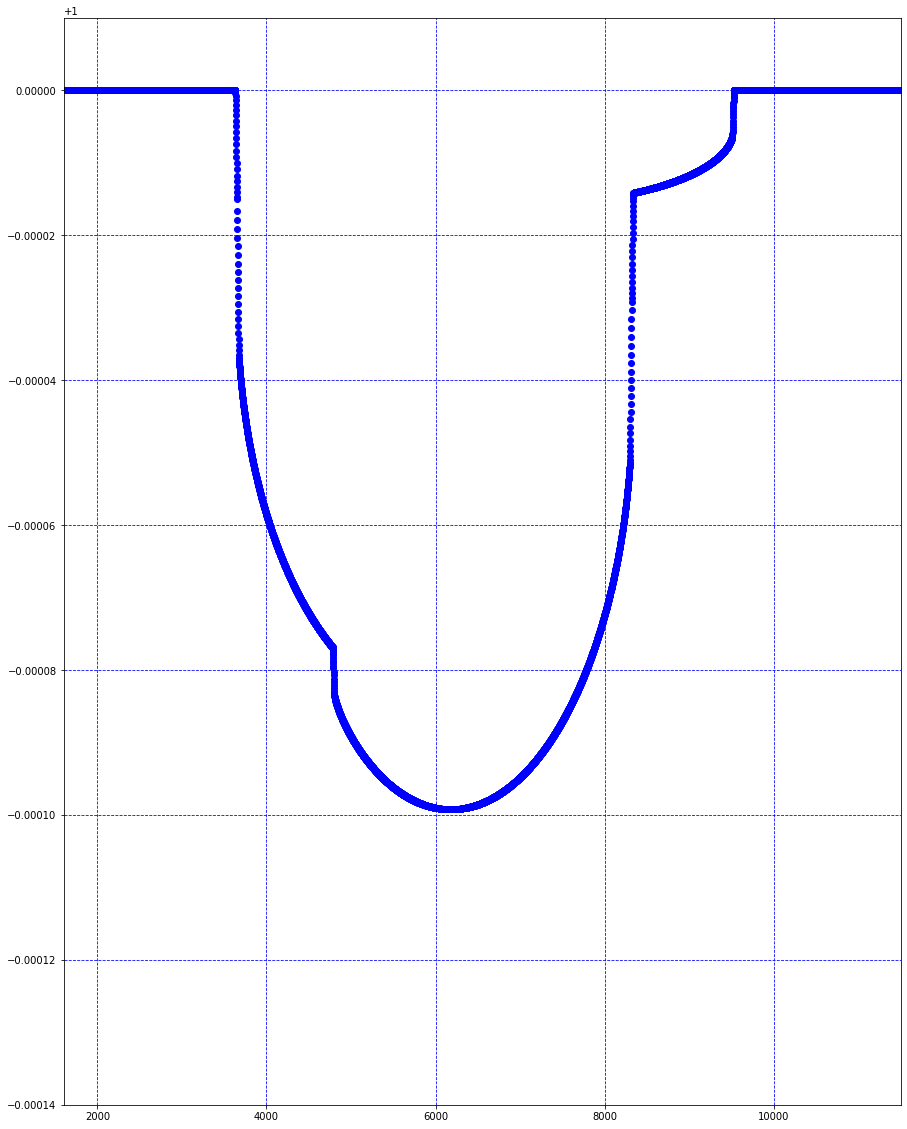

In [91]:
import matplotlib.pyplot as plt 

from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates

  
f=plt.figure(figsize=[15,20])
plt.gca().set_xlim([1600,11500])
plt.gca().set_ylim([0.99986,1.00001])
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10000))

ax = plt.gca()
ax.set_facecolor((1.0, 1, 1))
plt.plot(index,curve,'bo')

plt.grid(True,color='blue',linestyle="--")
plt.show()